# **GenoVarDis@IberLEF2024: Automatic Genomic Variants and Related Diseases using Named Entity Recognition with Large Language Models**

## Autor: Víctor Manuel Oliveros Villena


In [ ]:
# Esta es la ruta a la raíz de nuestro Drive.
# Si se prefiere otra ruta, añadir los directorios pertinentes a continuación de esta.
path_drive = '/content/drive/MyDrive'

### **Configuración del entorno**

In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import torch
import os
from google.colab import drive
import pandas as pd
import re
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
from transformers import pipeline

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### **Lectura de archivos**

In [ ]:
# Ruta al archivo TSV en Google Drive
path_test_text = path_drive + '/GenoVarDis/Data/test_text.tsv'
path_test_annotation = path_drive + '/GenoVarDis/Data/test_annotation.tsv'

# Leer el archivo TSV utilizando pandas
test_text = pd.read_csv(path_test_text, sep='\t')
test_annotation = pd.read_csv(path_test_annotation, sep='\t')

# Eliminacion de la columna mark, pues nos es irrelevante
test_annotation = test_annotation.drop('mark', axis=1)

# En caso de emplear el archivo dev como test:

# Ruta al archivo TSV en Google Drive
path_dev_text = path_drive + '/GenoVarDis/Data/dev_text.tsv'
path_dev_annotation = path_drive + '/GenoVarDis/Data/dev_annotation.tsv'

# Leer el archivo TSV utilizando pandas
dev_text = pd.read_csv(path_dev_text, sep='\t')
dev_annotation = pd.read_csv(path_dev_annotation, sep='\t')

# Eliminacion de la columna mark, pues nos es irrelevante
dev_annotation = dev_annotation.drop('mark', axis=1)

### **Estructura de las predicciones realizadas por nuestro modelo Fine-tuned RoBERTa**

In [ ]:
# Inicializar un pipeline de reconocimiento de entidades nombradas (NER) utilizando el modelo RoBERTa.
# Por defecto, empleamos el modelo con dev para validación, RoBERTa_DevVal. Para dev como test, usar RoBERTa_DevTest.
# La estrategia de agregación 'simple' se emplea para combinar las sub-palabras en entidades completas.
classifier = pipeline("ner", model= path_drive + "/GenoVarDis/Logs/RoBERTa_DevVal", aggregation_strategy="simple")

In [ ]:
# Caso clinico de ejemplo
example = dev_text.iloc[0]['text']
# Predicciones de nuestro modelo
pred_ex = classifier(example)

pred_ex

[{'entity_group': 'disease',
  'score': 0.7117006,
  'word': 'De',
  'start': 11,
  'end': 13},
 {'entity_group': 'disease',
  'score': 0.7860363,
  'word': 'ficiencia total de C4B',
  'start': 13,
  'end': 35},
 {'entity_group': 'disease',
  'score': 0.8122647,
  'word': ' infecciones',
  'start': 99,
  'end': 110},
 {'entity_group': 'disease',
  'score': 0.48034406,
  'word': ' deficiencias de los componentes tempranos',
  'start': 134,
  'end': 175},
 {'entity_group': 'gene',
  'score': 0.4142685,
  'word': ' clásica',
  'start': 186,
  'end': 193},
 {'entity_group': 'disease',
  'score': 0.49174666,
  'word': ' infecciones',
  'start': 307,
  'end': 318},
 {'entity_group': 'disease',
  'score': 0.76760745,
  'word': ' deficiencia total de C4B',
  'start': 359,
  'end': 383},
 {'entity_group': 'disease',
  'score': 0.85676455,
  'word': ' meningitis recurrente',
  'start': 413,
  'end': 434},
 {'entity_group': 'disease',
  'score': 0.76932395,
  'word': ' fístulas crónicas',
  'star

### **Generación del archivo TSV a partir de Fine-tuned RoBERTa**

In [ ]:
# Ruta donde guardar el archivo generado
filename = path_drive + '/GenoVarDis/EvaluationTSV/annotation_RoBERTa_DevVal.tsv'
# Etiquetas de las columnas del TSV
tags = 'pmid\tfilename\tlabel\toffset1\toffset2\tspan\n'

with open(filename, 'w') as file:
  # Escribimos las etiquetas de las columnas en el archivo
  file.write(tags)
  # Por cada caso clinico...
  # Al usar dev como validación, usamos test_text como test.
  # Para usar dev como test, cambiar test_text.iterrows() por dev_text.iterrows()
  for i, row in test_text.iterrows():
    text = row['text']        # Obtencion de texto del caso clinico
    pmid = row['pmid']        # Obtencion de pmid
    ann = f"pmid-{pmid}.ann"  # Obtencion del archivo ann

    predictions = classifier(text)  # Obtencion las predicciones de nuestro modelo

    # Por cada entidad detectada
    for entity in predictions:
      # Filtrado de entidades con score superior a 0.5
      if entity['score'] > 0.5:
        span = entity['word'].strip()         # Entidad detectada
        offset1 = entity['start']             # Posicion de incio
        offset2 = entity['end']               # Posicion de fin
        label = entity['entity_group']        # Tipo de entidad
        label = label[0].upper() + label[1:]  # Capitalizar primera letra
        # Añadir la entidad del TSV
        file.write(f"{pmid}\t{ann}\t{label}\t{offset1}\t{offset2}\t{span}\n")

# **Análisis de RoBERTa**


## **RoBERTa con Dev_text como test**

In [ ]:
# Ruta al archivo TSV en tu Google Drive
path_test_pred = path_drive + '/GenoVarDis/EvaluationTSV/annotation_RoBERTa_DevTest.tsv'

# Leer el archivo TSV utilizando pandas
test_pred = pd.read_csv(path_test_pred, sep='\t')

### *Curvas de aprendizaje*

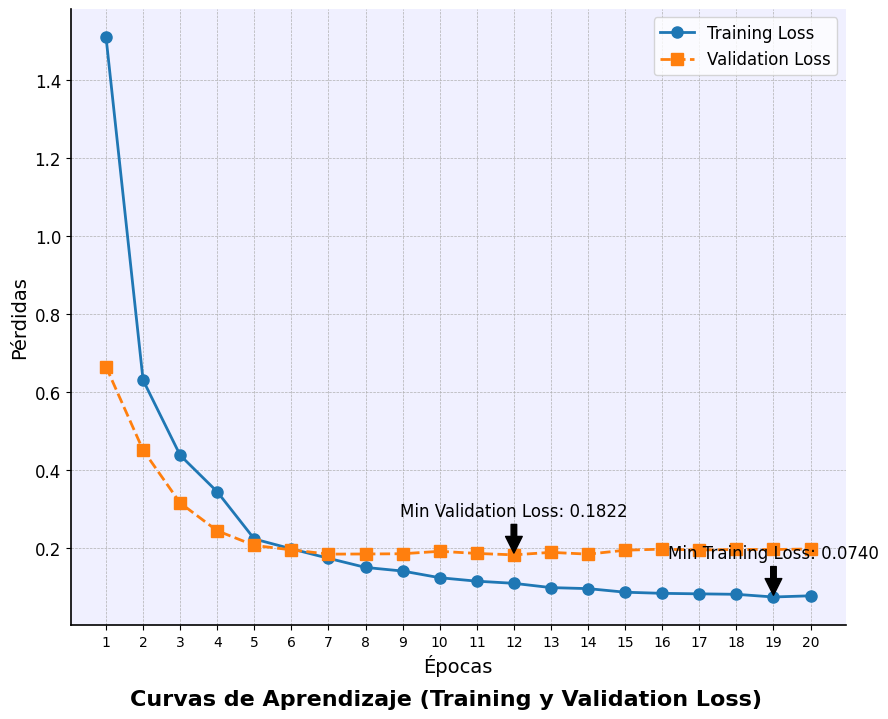

In [ ]:
# Pérdidas obtenidas durante el entrenamiento
training_loss = [1.511400, 0.630600, 0.437800, 0.344100, 0.222900, 0.197600, 0.173300,
    0.149900, 0.140600, 0.123500, 0.114600, 0.109100, 0.098100, 0.095500, 0.086300,
    0.083400, 0.082100, 0.080900, 0.074000, 0.077100]

validation_loss = [0.665041, 0.450983, 0.315294, 0.244024, 0.206363, 0.194973, 0.184059,
    0.184401, 0.185036, 0.191279, 0.185815, 0.182168, 0.188601, 0.183993,
    0.194102, 0.196870, 0.194591, 0.195982, 0.195931, 0.197207]

# Crear rango de épocas
epochs = range(1, len(training_loss) + 1)

# Crear el gráfico
plt.figure(figsize=(10, 8))

plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-', linewidth=2, markersize=8)
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--', linewidth=2, markersize=8)

plt.xlabel('Épocas', fontsize=14)
plt.ylabel('Pérdidas', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.xticks(range(1, len(training_loss) + 1))
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Mejorar el aspecto del borde y la cuadrícula
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.2)
plt.gca().spines['bottom'].set_linewidth(1.2)

# Añadir anotación para el mínimo de la pérdida de validación
min_validation_loss = min(validation_loss)
min_validation_loss_epoch = validation_loss.index(min_validation_loss) + 1

min_training_loss = min(training_loss)
min_training_loss_epoch = training_loss.index(min_training_loss) + 1

plt.annotate(f'Min Validation Loss: {min_validation_loss:.4f}', xy=(min_validation_loss_epoch, min_validation_loss),
             xytext=(min_validation_loss_epoch, min_validation_loss + 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, ha='center')

plt.annotate(f'Min Training Loss: {min_training_loss:.4f}', xy=(min_training_loss_epoch, min_training_loss),
             xytext=(min_training_loss_epoch, min_training_loss + 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, ha='center')

# Añadir el título en la parte inferior
plt.figtext(0.5, 0.01, 'Curvas de Aprendizaje (Training y Validation Loss)', wrap=True,
            horizontalalignment='center', fontsize=16, fontweight='bold')

plt.gca().set_facecolor('#f0f0ff')

# Mostrar el gráfico
plt.show()


### *Evolución de las métricas durante cada época del entrenamiento*

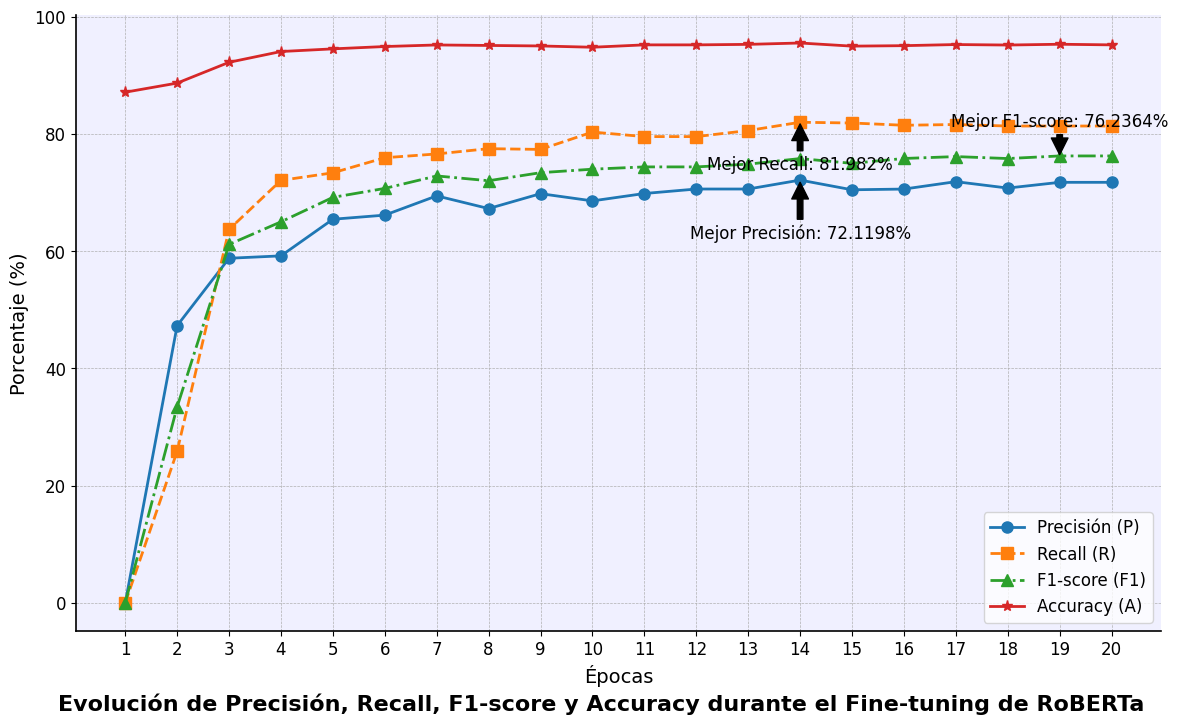

In [ ]:
# Metricas obtenidas durante el entrenamiento
precision = [0.0, 47.2941, 58.7886, 59.1966, 65.442, 66.1435, 69.4282, 67.2626, 69.8026, 68.5714,
             69.8305, 70.595, 70.595, 72.1198, 70.4646, 70.5882, 71.8502, 70.7589, 71.7367, 71.7367]
recall = [0.0, 25.8687, 63.7066, 72.0721, 73.3591, 75.9331, 76.5766, 77.4775, 77.3488, 80.3089,
          79.5367, 79.5367, 80.5663, 81.982, 81.8533, 81.4672, 81.596, 81.3385, 81.3385, 81.3385]
f1_score = [0.0, 33.4443, 61.1489, 65.0029, 69.1748, 70.701, 72.8274, 72.0096, 73.3822, 73.9775,
            74.3682, 74.3682, 74.834, 75.7882, 74.9736, 75.8045, 76.1266, 75.7928, 76.2364, 76.2364]
accuracy = [87.1055, 88.6588, 92.2051, 94.0421, 94.4961, 94.8933, 95.1628, 95.0777, 94.9926, 94.7727,
            95.177, 95.177, 95.2621, 95.4961, 94.961, 95.0422, 95.2337, 95.1486, 95.2834, 95.177]


# Crear el gráfico
epochs = range(1, 21)

# Crear el gráfico nuevamente con el título en la parte inferior
plt.figure(figsize=(14, 8))

plt.plot(epochs, precision, label='Precisión (P)', marker='o', linestyle='-', linewidth=2, markersize=8)
plt.plot(epochs, recall, label='Recall (R)', marker='s', linestyle='--', linewidth=2, markersize=8)
plt.plot(epochs, f1_score, label='F1-score (F1)', marker='^', linestyle='-.', linewidth=2, markersize=8)
plt.plot(epochs, accuracy, label='Accuracy (A)', marker='*', linestyle='-', linewidth=2, markersize=8)

plt.xlabel('Épocas', fontsize=14)
plt.ylabel('Porcentaje (%)', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.xticks(epochs, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Mejorar el aspecto del borde y la cuadrícula
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.2)
plt.gca().spines['bottom'].set_linewidth(1.2)

# Añadir anotaciones para el mejor punto en cada métrica
best_precision_epoch = precision.index(max(precision)) + 1
best_recall_epoch = recall.index(max(recall)) + 1
best_f1_epoch = f1_score.index(max(f1_score)) + 1

plt.annotate(f'Mejor Precisión: {max(precision)}%', xy=(best_precision_epoch, max(precision)),
             xytext=(best_precision_epoch, max(precision) - 10),  # Ajuste vertical aquí
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, ha='center')

plt.annotate(f'Mejor Recall: {max(recall)}%', xy=(best_recall_epoch, max(recall)),
             xytext=(best_recall_epoch, max(recall) - 8),  # Ajuste vertical aquí
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, ha='center')

plt.annotate(f'Mejor F1-score: {max(f1_score)}%', xy=(best_f1_epoch, max(f1_score)),
             xytext=(best_f1_epoch, max(f1_score) + 5),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, ha='center')

# Añadir el título en la parte inferior
plt.figtext(0.5, 0.01, 'Evolución de Precisión, Recall, F1-score y Accuracy durante el Fine-tuning de RoBERTa',
            wrap=True, horizontalalignment='center', fontsize=16, fontweight='bold')

plt.gca().set_facecolor('#f0f0ff')

# Mostrar el gráfico
plt.show()

### *Gráfica de frecuencias*

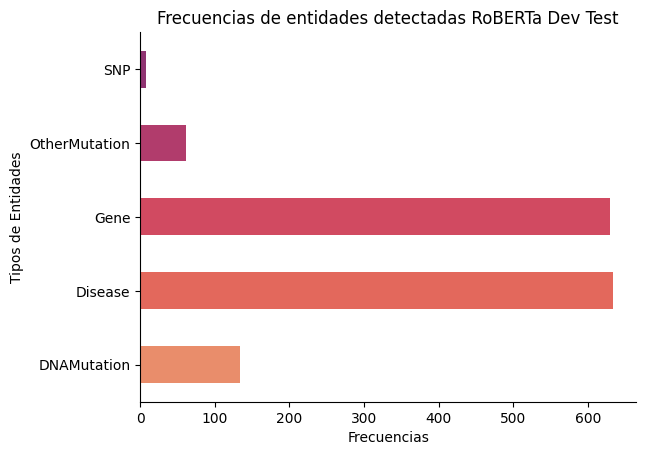

In [ ]:
# Frecuencias de cada tipo de entidad detectado
test_pred.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('flare'))
plt.title('Frecuencias de entidades detectadas RoBERTa Dev Test')
plt.xlabel('Frecuencias')
plt.ylabel('Tipos de Entidades')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
frecuencia_labels = test_pred['label'].value_counts()

print(frecuencia_labels)

label
Disease          633
Gene             630
DNAMutation      134
OtherMutation     61
SNP                8
Name: count, dtype: int64


### *Desglose de los resultados*

In [ ]:
# Combina los dataframes basándote en las columnas relevantes
merged_test = pd.merge(test_pred, dev_annotation, on=['pmid', 'filename', 'offset1', 'offset2', 'span'], suffixes=('_pred', '_true'))
# Filtrar el DataFrame para incluir solo las filas donde label_pred y label_true coincidan
matching_test = merged_test[merged_test['label_pred'] == merged_test['label_true']]

# Extrae las etiquetas predichas y las verdaderas
y_pred = merged_test['label_pred']
y_true = merged_test['label_true']

len_merged = len(merged_test)
len_pred = len(test_pred)
len_matching = len(matching_test)
false_pos = len_pred - len_merged

# print(len(y_pred), len(y_true))
print(f"Predicciones realizadas: {len_pred}")
print(f"Falsos positivos: {false_pos} ({(false_pos * 100 / len_pred):.2f}%)")
print(f"Entidades detectadas correctamente: {len_merged}")
print(f"Entidades detectadas y clasificadas correctamente: {len_matching} ({(len_matching * 100 / len_pred):.2f}% de las predicciones)\n")

Predicciones realizadas: 1466
Falsos positivos: 581 (39.63%)
Entidades detectadas correctamente: 885
Entidades detectadas y clasificadas correctamente: 864 (58.94% de las predicciones)



### *Matriz de confusión*

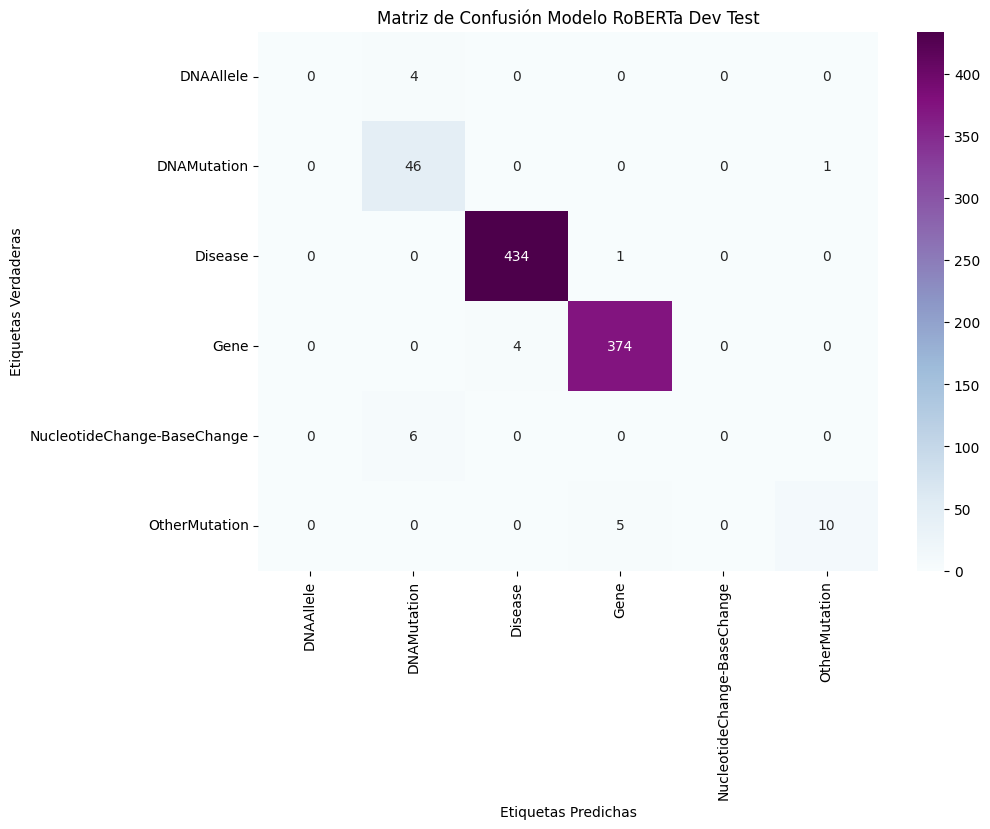

In [ ]:
# Genera la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred, labels=sorted(y_true.unique()))

# Visualiza la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='BuPu', xticklabels=sorted(y_true.unique()), yticklabels=sorted(y_true.unique()))
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión Modelo RoBERTa Dev Test')
plt.show()

### *Gráficas de distribución*

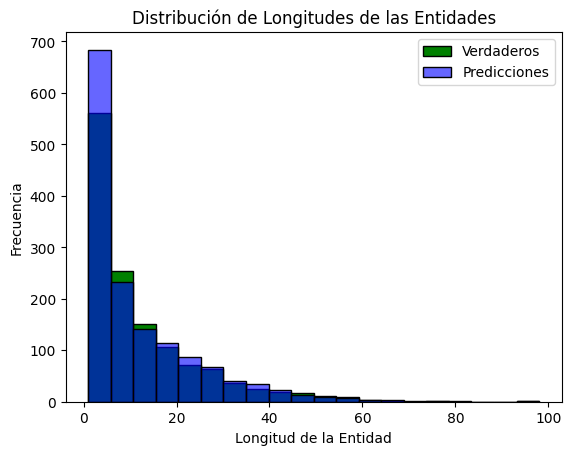

In [ ]:
# Histograma de las longitudes de las entidades verdaderas
sns.histplot(dev_annotation['offset2'] - dev_annotation['offset1'], bins=20, color='green', alpha=1, label='Verdaderos')
# Histograma de las longitudes de las entidades predichas
sns.histplot(test_pred['offset2'] - test_pred['offset1'], bins=20, color='blue', alpha=0.6, label='Predicciones')
plt.xlabel('Longitud de la Entidad')
plt.ylabel('Frecuencia')
plt.title('Distribución de Longitudes de las Entidades')
plt.legend()
plt.show()


## **RoBERTa con Dev_text como validación**

In [ ]:
# Ruta al archivo TSV en tu Google Drive
path_test_pred = path_drive + '/GenoVarDis/EvaluationTSV/annotation_RoBERTa_DevVal.tsv'

# Leer el archivo TSV utilizando pandas
test_pred = pd.read_csv(path_test_pred, sep='\t')

### *Curvas de aprendizaje*

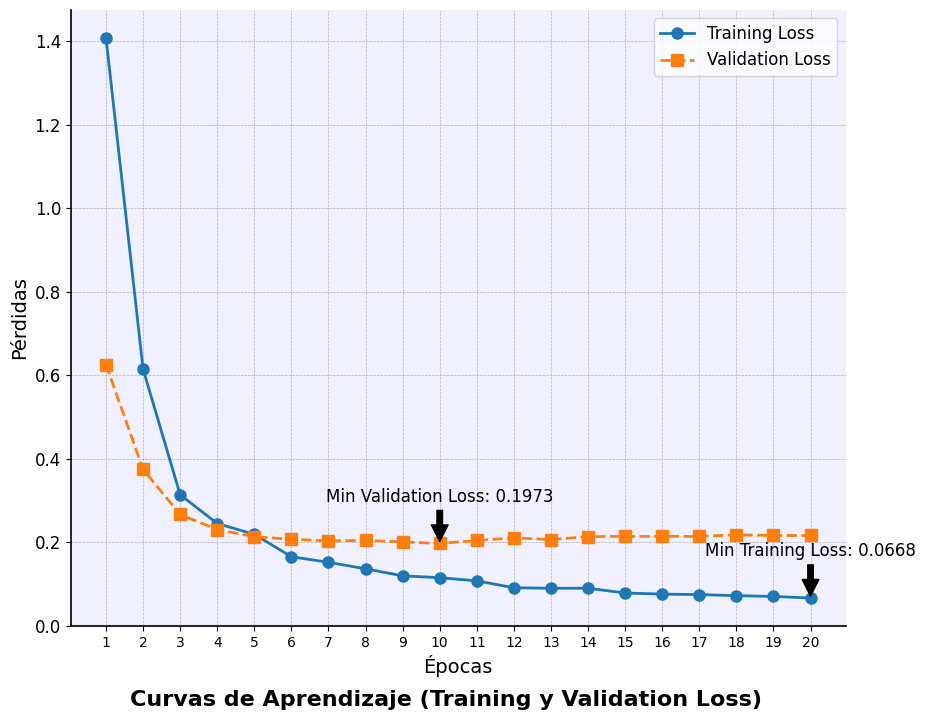

In [ ]:
# Perdidas obtenidas durante el transcurso del entrenamiento
training_loss = [1.407300, 0.614700, 0.313900, 0.245100, 0.219200, 0.165600, 0.152300,
                 0.136600, 0.119800, 0.115500, 0.107800, 0.091300, 0.090100, 0.090300,
                 0.078700, 0.076100, 0.075000, 0.072400, 0.070500, 0.066800]
validation_loss = [0.625543, 0.374606, 0.266682, 0.230608, 0.213494, 0.207407, 0.203427,
                   0.204733, 0.201074, 0.197284, 0.204496, 0.210696, 0.206691, 0.213762,
                   0.214202, 0.214365, 0.214048, 0.218142, 0.216484, 0.216410]

# Crear rango de épocas
epochs = range(1, len(training_loss) + 1)

# Crear el gráfico
plt.figure(figsize=(10, 8))

plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-', linewidth=2, markersize=8)
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--', linewidth=2, markersize=8)

plt.xlabel('Épocas', fontsize=14)
plt.ylabel('Pérdidas', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.xticks(range(1, len(training_loss) + 1))
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Mejorar el aspecto del borde y la cuadrícula
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.2)
plt.gca().spines['bottom'].set_linewidth(1.2)

# Añadir anotación para el mínimo de la pérdida de validación
min_validation_loss = min(validation_loss)
min_validation_loss_epoch = validation_loss.index(min_validation_loss) + 1

min_training_loss = min(training_loss)
min_training_loss_epoch = training_loss.index(min_training_loss) + 1

plt.annotate(f'Min Validation Loss: {min_validation_loss:.4f}', xy=(min_validation_loss_epoch, min_validation_loss),
             xytext=(min_validation_loss_epoch, min_validation_loss + 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, ha='center')

plt.annotate(f'Min Training Loss: {min_training_loss:.4f}', xy=(min_training_loss_epoch, min_training_loss),
             xytext=(min_training_loss_epoch, min_training_loss + 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, ha='center')

# Añadir el título en la parte inferior
plt.figtext(0.5, 0.01, 'Curvas de Aprendizaje (Training y Validation Loss)', wrap=True,
            horizontalalignment='center', fontsize=16, fontweight='bold')

plt.gca().set_facecolor('#f0f0ff')

# Mostrar el gráfico
plt.show()


### *Evolución de las métricas durante cada época del entrenamiento*

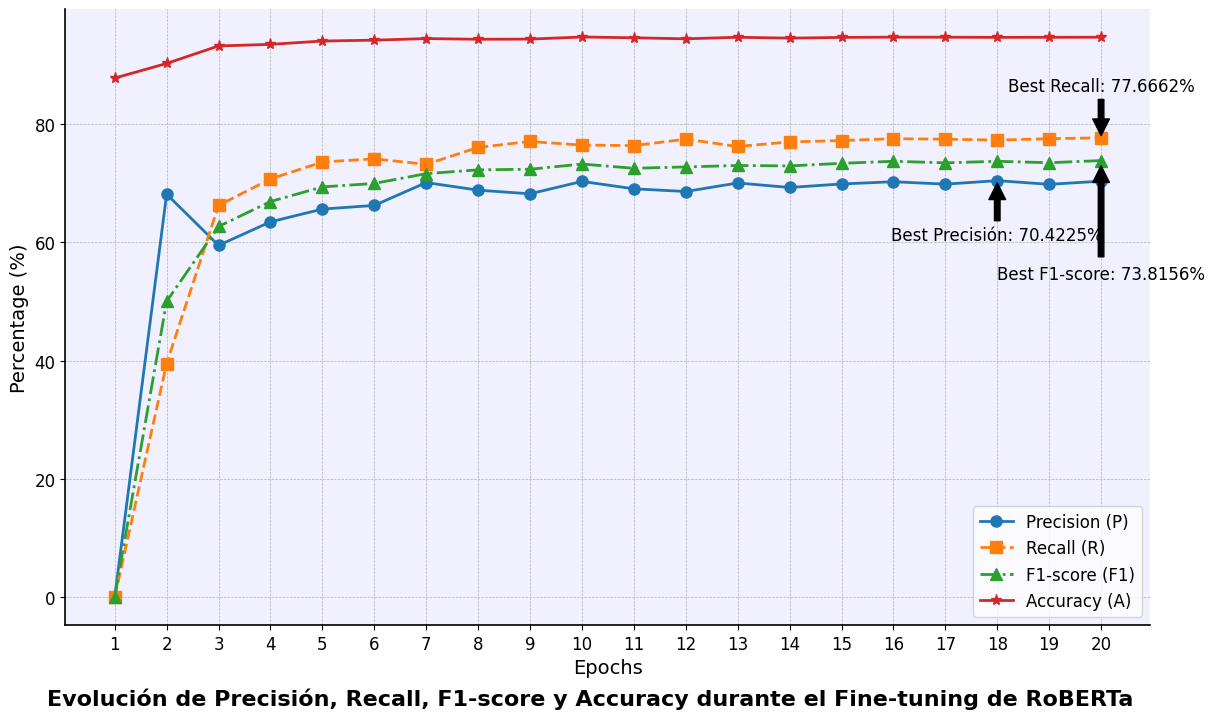

In [ ]:
# Evolucion de las metricas durante las distinas epocas del entrenamiento
precision = [0.0, 68.1333, 59.4726, 63.4535, 65.6099, 66.2293, 70.0962, 68.8112, 68.1943, 70.2914, 69.0426, 68.5832, 70.0284, 69.2629, 69.8601, 70.2381, 69.8258, 70.4225, 69.7982, 70.3289]
recall = [0.0, 39.49, 66.2287, 70.711, 73.5703, 74.1113, 73.1839, 76.0433, 77.0479, 76.4297, 76.3524, 77.4343, 76.1978, 76.9706, 77.2025, 77.5116, 77.4343, 77.2798, 77.5116, 77.6662]
f1_score = [0.0, 50.0, 62.6691, 66.886, 69.3625, 69.9489, 71.6068, 72.2467, 72.3512, 73.2321, 72.5138, 72.7405, 72.983, 72.9136, 73.348, 73.6958, 73.4335, 73.692, 73.4529, 73.8156]
accuracy = [87.7693, 90.2404, 93.2033, 93.47, 94.0326, 94.1826, 94.4493, 94.3326, 94.3618, 94.716, 94.5827, 94.4076, 94.6743, 94.5201, 94.6493, 94.6868, 94.6827, 94.6535, 94.666, 94.6785]


# Crear el gráfico
epochs = range(1, 21)

# Crear el gráfico nuevamente con el título en la parte inferior
plt.figure(figsize=(14, 8))

plt.plot(epochs, precision, label='Precision (P)', marker='o', linestyle='-', linewidth=2, markersize=8)
plt.plot(epochs, recall, label='Recall (R)', marker='s', linestyle='--', linewidth=2, markersize=8)
plt.plot(epochs, f1_score, label='F1-score (F1)', marker='^', linestyle='-.', linewidth=2, markersize=8)
plt.plot(epochs, accuracy, label='Accuracy (A)', marker='*', linestyle='-', linewidth=2, markersize=8)

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.xticks(epochs, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Mejorar el aspecto del borde y la cuadrícula
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.2)
plt.gca().spines['bottom'].set_linewidth(1.2)

# Añadir anotaciones para el mejor punto en cada métrica
best_precision_epoch = precision.index(max(precision)) + 1
best_recall_epoch = recall.index(max(recall)) + 1
best_f1_epoch = f1_score.index(max(f1_score)) + 1

plt.annotate(f'Best Precisión: {max(precision)}%', xy=(best_precision_epoch, max(precision)),
             xytext=(best_precision_epoch, max(precision) - 10),  # Ajuste vertical aquí
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, ha='center')

plt.annotate(f'Best Recall: {max(recall)}%', xy=(best_recall_epoch, max(recall)),
             xytext=(best_recall_epoch, max(recall) + 8),  # Ajuste vertical aquí
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, ha='center')

plt.annotate(f'Best F1-score: {max(f1_score)}%', xy=(best_f1_epoch, max(f1_score)),
             xytext=(best_f1_epoch, max(f1_score) - 20),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, ha='center')

# Añadir el título en la parte inferior
plt.figtext(0.5, 0.01, 'Evolución de Precisión, Recall, F1-score y Accuracy durante el Fine-tuning de RoBERTa',
            wrap=True, horizontalalignment='center', fontsize=16, fontweight='bold')

plt.gca().set_facecolor('#f0f0ff')

# Mostrar el gráfico
plt.show()

### *Gráficas de frecuencias*

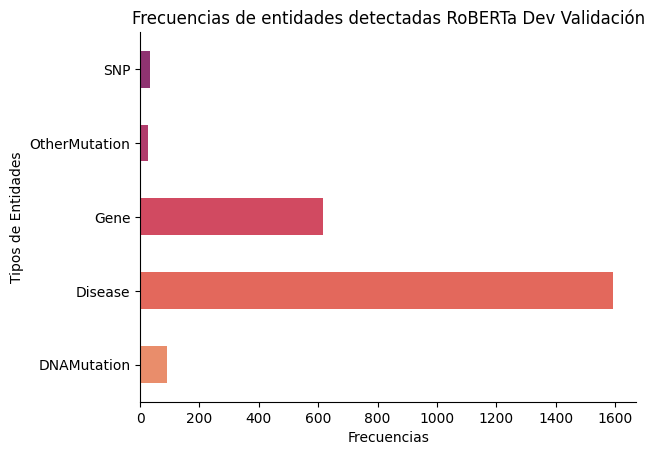

In [ ]:
test_pred.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('flare'))
plt.title('Frecuencias de entidades detectadas RoBERTa Dev Validación')
plt.xlabel('Frecuencias')
plt.ylabel('Tipos de Entidades')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
frecuencia_labels = test_pred['label'].value_counts()
print(frecuencia_labels)

label
Disease          1592
Gene              616
DNAMutation        89
SNP                32
OtherMutation      25
Name: count, dtype: int64


### *Desglose de los resultados*

In [ ]:
# Combina los dataframes basándote en las columnas relevantes
merged_test = pd.merge(test_pred, test_annotation, on=['pmid', 'filename', 'offset1', 'offset2', 'span'], suffixes=('_pred', '_true'))
# Filtrar el DataFrame para incluir solo las filas donde label_pred y label_true coincidan
matching_test = merged_test[merged_test['label_pred'] == merged_test['label_true']]

# Extrae las etiquetas predichas y las verdaderas
y_pred = merged_test['label_pred']
y_true = merged_test['label_true']

len_merged = len(merged_test)
len_pred = len(test_pred)
len_matching = len(matching_test)
false_pos = len_pred - len_merged

# print(len(y_pred), len(y_true))
print(f"Predicciones realizadas: {len_pred}")
print(f"Falsos positivos: {false_pos} ({(false_pos * 100 / len_pred):.2f}%)")
print(f"Entidades detectadas correctamente: {len_merged}")
print(f"Entidades detectadas y clasificadas correctamente: {len_matching} ({(len_matching * 100 / len_pred):.2f}% de las predicciones)\n")

Predicciones realizadas: 2354
Falsos positivos: 958 (40.70%)
Entidades detectadas correctamente: 1396
Entidades detectadas y clasificadas correctamente: 1387 (58.92% de las predicciones)



### *Matriz de confusión*

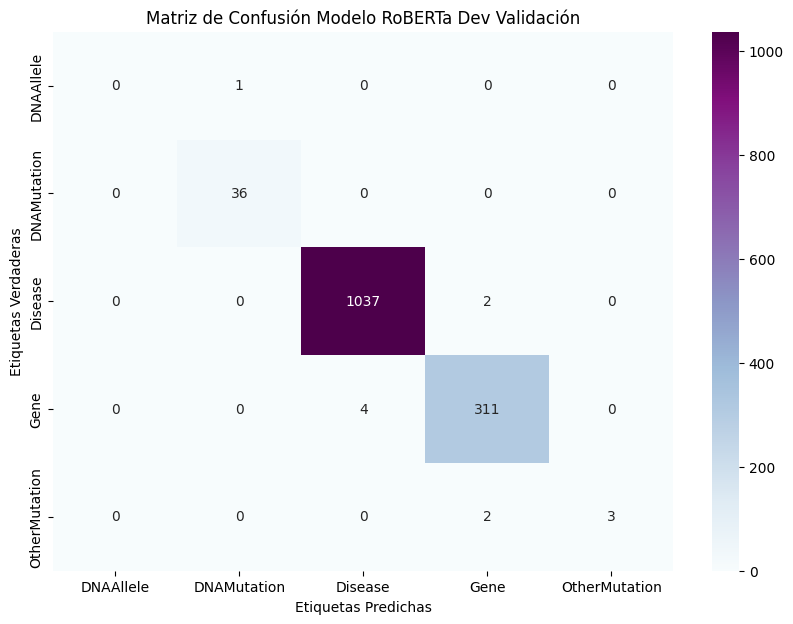

In [ ]:
# Genera la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred, labels=sorted(y_true.unique()))

# Visualiza la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='BuPu', xticklabels=sorted(y_true.unique()), yticklabels=sorted(y_true.unique()))
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión Modelo RoBERTa Dev Validación')
plt.show()

### *Gráficas de distribución*

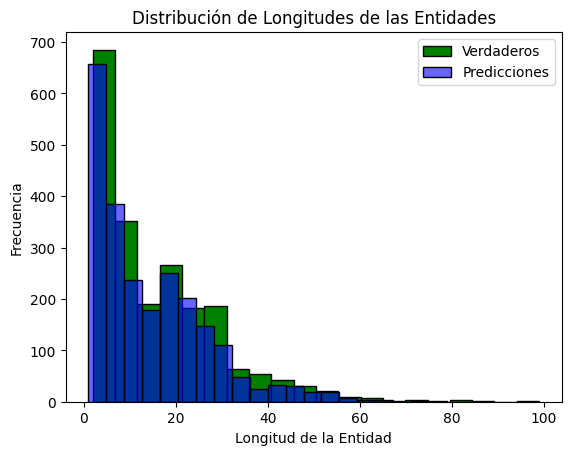

In [ ]:
# Histograma de las longitudes de las entidades verdaderas
sns.histplot(test_annotation['offset2'] - test_annotation['offset1'], bins=20, color='green', alpha=1, label='Verdaderos')
# Histograma de las longitudes de las entidades predichas
sns.histplot(test_pred['offset2'] - test_pred['offset1'], bins=20, color='blue', alpha=0.6, label='Predicciones')
plt.xlabel('Longitud de la Entidad')
plt.ylabel('Frecuencia')
plt.title('Distribución de Longitudes de las Entidades')
plt.legend()
plt.show()